In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import shap
import xgboost as xgb
import sys

In [26]:
print('xgboost version', xgb.__version__)
print('python version', sys.version)
print('shap.__version__')


xgboost version 2.0.3
python version 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:38:07) [Clang 16.0.6 ]
shap.__version__


In [3]:
shap.initjs()


Reference https://www.kaggle.com/code/maryanalyze/interpret-xgboost-pdp-ice-lime-shap

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [5]:
df = pd.read_csv('./train.csv')


In [6]:
df = pd.read_csv('train.csv') #reading data
df.replace('?',np.NaN, inplace=True)



df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1) #dropping columns that are not useful for classifcation
df = df.dropna(axis=0) #dropping nan rows
df.dropna(inplace=True)

le = preprocessing.LabelEncoder() #encoding the categorical variables into numericals
df['Sex'] = le.fit_transform(df['Sex']) #{'female': 0, 'male': 1}
df['Embarked'] = le.fit_transform(df['Embarked']) #{'C': 0, 'Q': 1, 'S': 2}

In [7]:
X = df[['Pclass',  'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked']]
y = df["Survived"].values
train_dataset, test_dataset, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify = y) #train test split
X_train = train_dataset.drop('Survived', axis=1)
X_test = test_dataset.drop('Survived', axis=1)



model = xgb.XGBClassifier(eval_metric = 'logloss', n_estimators = 1000, early_stopping_rounds = 5)
model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)],  verbose = False)
bst = model.get_booster()
print('Best num_boost_rounds:', bst.best_iteration)
print('Best negative Logloss:', np.round(bst.best_score,4))

Best num_boost_rounds: 7
Best negative Logloss: 0.4349


In [9]:
feature_names = X_train.columns

In [10]:
sorted(dict(zip(feature_names,model.feature_importances_)).items(), key = lambda x: -x[1])

[('Sex', 0.66446114),
 ('Pclass', 0.15767875),
 ('SibSp', 0.096038565),
 ('Age', 0.029049417),
 ('Fare', 0.024019497),
 ('Parch', 0.017279727),
 ('Embarked', 0.011472901)]

## Summary plot

In [11]:
explainer = shap.TreeExplainer(model, data = None, feature_perturbation='tree_path_dependent',
                              feature_names = feature_names)
shap_values = explainer.shap_values(X_train[feature_names].values)

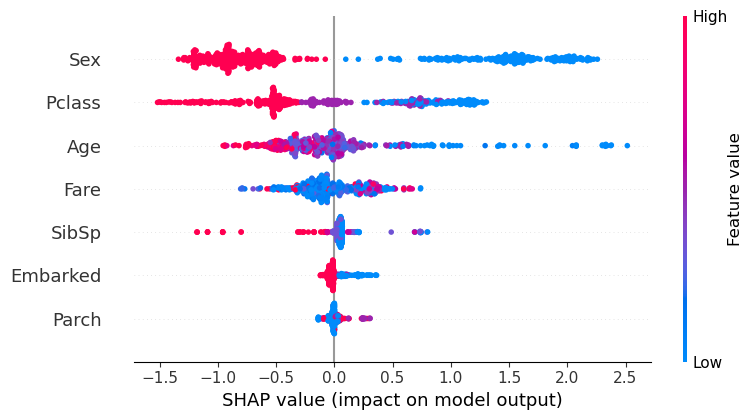

In [13]:
shap.summary_plot(shap_values, X_train[feature_names])

## Force plot

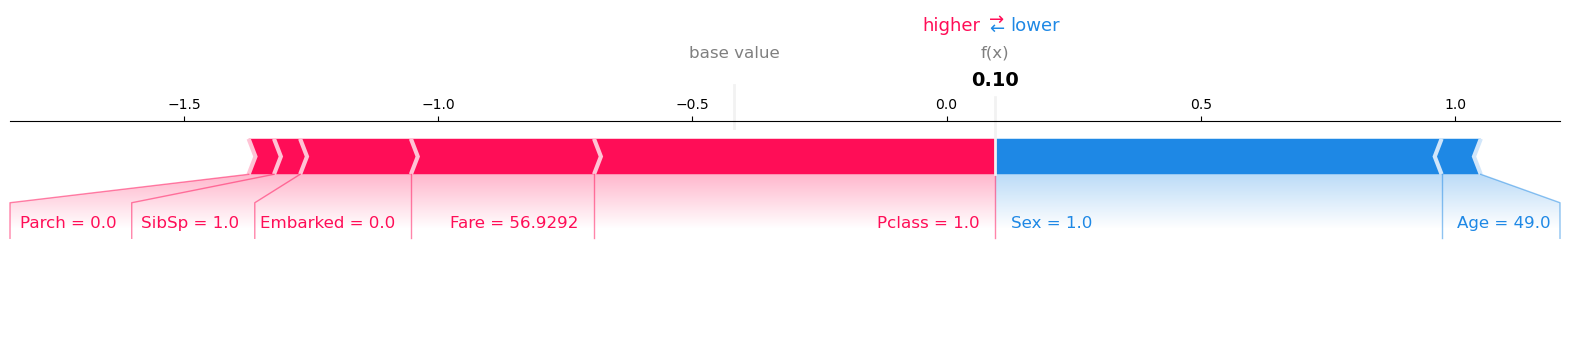

In [15]:
irow = 0
p = shap.force_plot(explainer.expected_value, shap_values[irow,:], X_train[feature_names].iloc[irow], matplotlib = True, show = True)

In [16]:
# plt.savefig('tmp.svg')
# plt.close()

## Waterfall plot

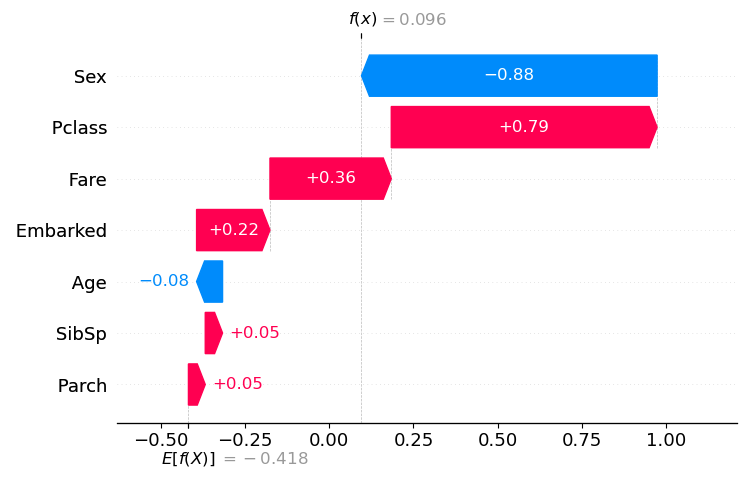

In [32]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
irow = 0

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[irow,:], X_train[feature_names].iloc[irow], max_display=20)

## Interaction plot

In [21]:
shap_interaction_values = explainer.shap_interaction_values(X_train[feature_names])
# diagonal values are the main effect for each feature
# off-diagonal values are interactions, symmetric
irows = 0
df_tmp = pd.DataFrame(shap_interaction_values[irow], columns = feature_names)
df_tmp.style.background_gradient(axis=None)\
    .format(precision=3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.918,-0.132,0.190,-0.004,0.002,-0.160,-0.026
1,-0.132,-0.882,0.020,0.016,0.009,0.042,0.048
2,0.190,0.020,-0.332,-0.048,0.009,0.058,0.027
3,-0.004,0.016,-0.048,0.085,0.000,0.005,-0.002
4,0.002,0.009,0.009,0.000,-0.025,0.024,0.030
5,-0.160,0.042,0.058,0.005,0.024,0.364,0.027
6,-0.026,0.048,0.027,-0.002,0.030,0.027,0.113


In [22]:
# check that the sum of main effect and interactions with other features
# is equal to the shap values for each feature
df_tmp.sum(1) == shap_values[irow,:]

0    False
1     True
2    False
3     True
4     True
5     True
6     True
dtype: bool

## Dependence plot

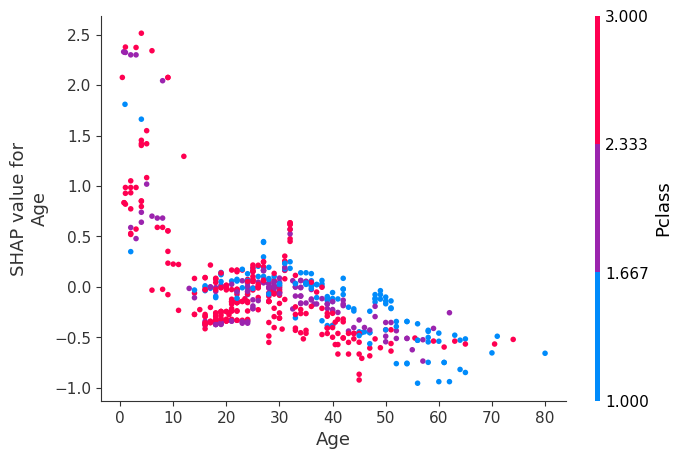

In [23]:
shap.dependence_plot('Age', shap_values, X_train[feature_names])

In [ ]:
df_train